# F&B Process Data Exploration
# Honeywell Hackathon - Anomaly Detection System
#
# This script explores the food & beverage manufacturing process data to understand patterns, distributions, and relationships between parameters.

# Import required libraries

In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [28]:
#Import custom modules
import sys
sys.path.append('..')
from src.data_processor import DataProcessor
from src.config import PROCESS_PARAMS, DATA_CONFIG

# 1. Load and Inspect Data

In [29]:
# Initialize data processor
processor = DataProcessor()

# Load data
file_path = '../data/raw/FnB_Process_Data_Batch_Wise.xlsx'
process_data, quality_data = processor.load_data(file_path)

print(f"Process data shape: {process_data.shape}")
print(f"Quality data batches: {len(quality_data)}")
print("\nFirst 5 rows of process data:")
print(process_data.head())

2025-08-23 19:58:01.007 | INFO     | src.data_processor:__init__:34 - DataProcessor initialized
2025-08-23 19:58:01.022 | INFO     | src.data_processor:load_data:50 - Loading data from ../data/raw/FnB_Process_Data_Batch_Wise.xlsx
2025-08-23 19:58:01.873 | INFO     | src.data_processor:load_data:74 - Loaded 1500 rows of process data
2025-08-23 19:58:01.878 | INFO     | src.data_processor:load_data:75 - Loaded quality data for 25 batches


Process data shape: (1500, 12)
Quality data batches: 25

First 5 rows of process data:
   Batch_ID  Time  Flour (kg)  Sugar (kg)  Yeast (kg)  Water Temp (C)  \
0         1     0    9.665776    4.873814    1.905794       24.835601   
1         1     1    9.697343    4.829029    2.128480       24.738654   
2         1     2   10.283522    5.027350    1.881150       24.920889   
3         1     3   10.218504    5.190817    2.121848       25.810604   
4         1     4    9.891061    5.170880    2.034122       25.650082   

   Salt (kg)  Mixer Speed (RPM)  Mixing Temp (C)  Fermentation Temp (C)  \
0   0.989292         150.837154        34.839420              36.682875   
1   1.073903         151.711438        34.561631              37.037835   
2   1.035247         155.260479        35.177363              36.791121   
3   0.982195         156.019976        35.091781              37.000395   
4   1.003725         158.813999        36.721006              37.119620   

   Oven Temp (C)  Oven 

In [30]:
# Data information
print("Data Types:")
print(process_data.dtypes)
print("\nData Info:")
process_data.info()

Data Types:
Batch_ID                   int64
Time                       int64
Flour (kg)               float64
Sugar (kg)               float64
Yeast (kg)               float64
Water Temp (C)           float64
Salt (kg)                float64
Mixer Speed (RPM)        float64
Mixing Temp (C)          float64
Fermentation Temp (C)    float64
Oven Temp (C)            float64
Oven Humidity (%)        float64
dtype: object

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Batch_ID               1500 non-null   int64  
 1   Time                   1500 non-null   int64  
 2   Flour (kg)             1500 non-null   float64
 3   Sugar (kg)             1500 non-null   float64
 4   Yeast (kg)             1500 non-null   float64
 5   Water Temp (C)         1500 non-null   float64
 6   Salt (kg)              1500 non-null  

# 2. Data Cleaning and Preprocessing

In [31]:
# Clean the data
clean_data = processor.clean_data(process_data)

print(f"Clean data shape: {clean_data.shape}")
print(f"Unique batches: {clean_data['Batch_ID'].nunique()}")
print(f"Time points per batch: {clean_data.groupby('Batch_ID').size().mean():.0f}")

2025-08-23 19:58:02.041 | INFO     | src.data_processor:clean_data:93 - Starting data cleaning process
2025-08-23 19:58:02.062 | INFO     | src.data_processor:clean_data:104 - Missing values before cleaning: 0
2025-08-23 19:58:02.141 | INFO     | src.data_processor:clean_data:117 - Missing values after cleaning: 0
2025-08-23 19:58:02.152 | INFO     | src.data_processor:clean_data:122 - Data cleaned: 1500 rows remaining


Clean data shape: (1500, 12)
Unique batches: 25
Time points per batch: 60


In [32]:
# Check for missing values
missing_values = clean_data.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found after cleaning!")

No missing values found after cleaning!


# 3. Statistical Analysis

In [33]:
# Basic statistics
process_params = list(PROCESS_PARAMS.keys())
statistics = clean_data[process_params].describe()

# Add ideal values for comparison
ideal_values = pd.Series({param: config['ideal'] for param, config in PROCESS_PARAMS.items()})
statistics.loc['ideal'] = ideal_values

print("Statistical Summary with Ideal Values:")
print(statistics.round(2))

# Calculate coefficient of variation for each parameter
cv_analysis = pd.DataFrame({
    'Parameter': process_params,
    'Mean': clean_data[process_params].mean(),
    'Std Dev': clean_data[process_params].std(),
    'CV (%)': (clean_data[process_params].std() / clean_data[process_params].mean() * 100)
})

cv_analysis = cv_analysis.sort_values('CV (%)', ascending=False)
print("Coefficient of Variation Analysis:")
print(cv_analysis)

Statistical Summary with Ideal Values:
       Flour (kg)  Sugar (kg)  Yeast (kg)  Water Temp (C)  Salt (kg)  \
count     1500.00     1500.00     1500.00         1500.00    1500.00   
mean        10.00        5.00        2.00           26.49       1.00   
std          0.30        0.19        0.10            0.92       0.05   
min          8.87        4.34        1.70           24.43       0.85   
25%          9.80        4.87        1.94           25.75       0.96   
50%         10.00        4.99        2.00           26.49       1.00   
75%         10.20        5.13        2.07           27.24       1.03   
max         11.00        5.56        2.30           28.64       1.18   
ideal       10.00        5.00        2.00           26.50       1.00   

       Mixer Speed (RPM)  Mixing Temp (C)  Fermentation Temp (C)  \
count            1500.00          1500.00                1500.00   
mean              150.18            37.94                  37.00   
std                14.51            

# 4. Distribution Analysis

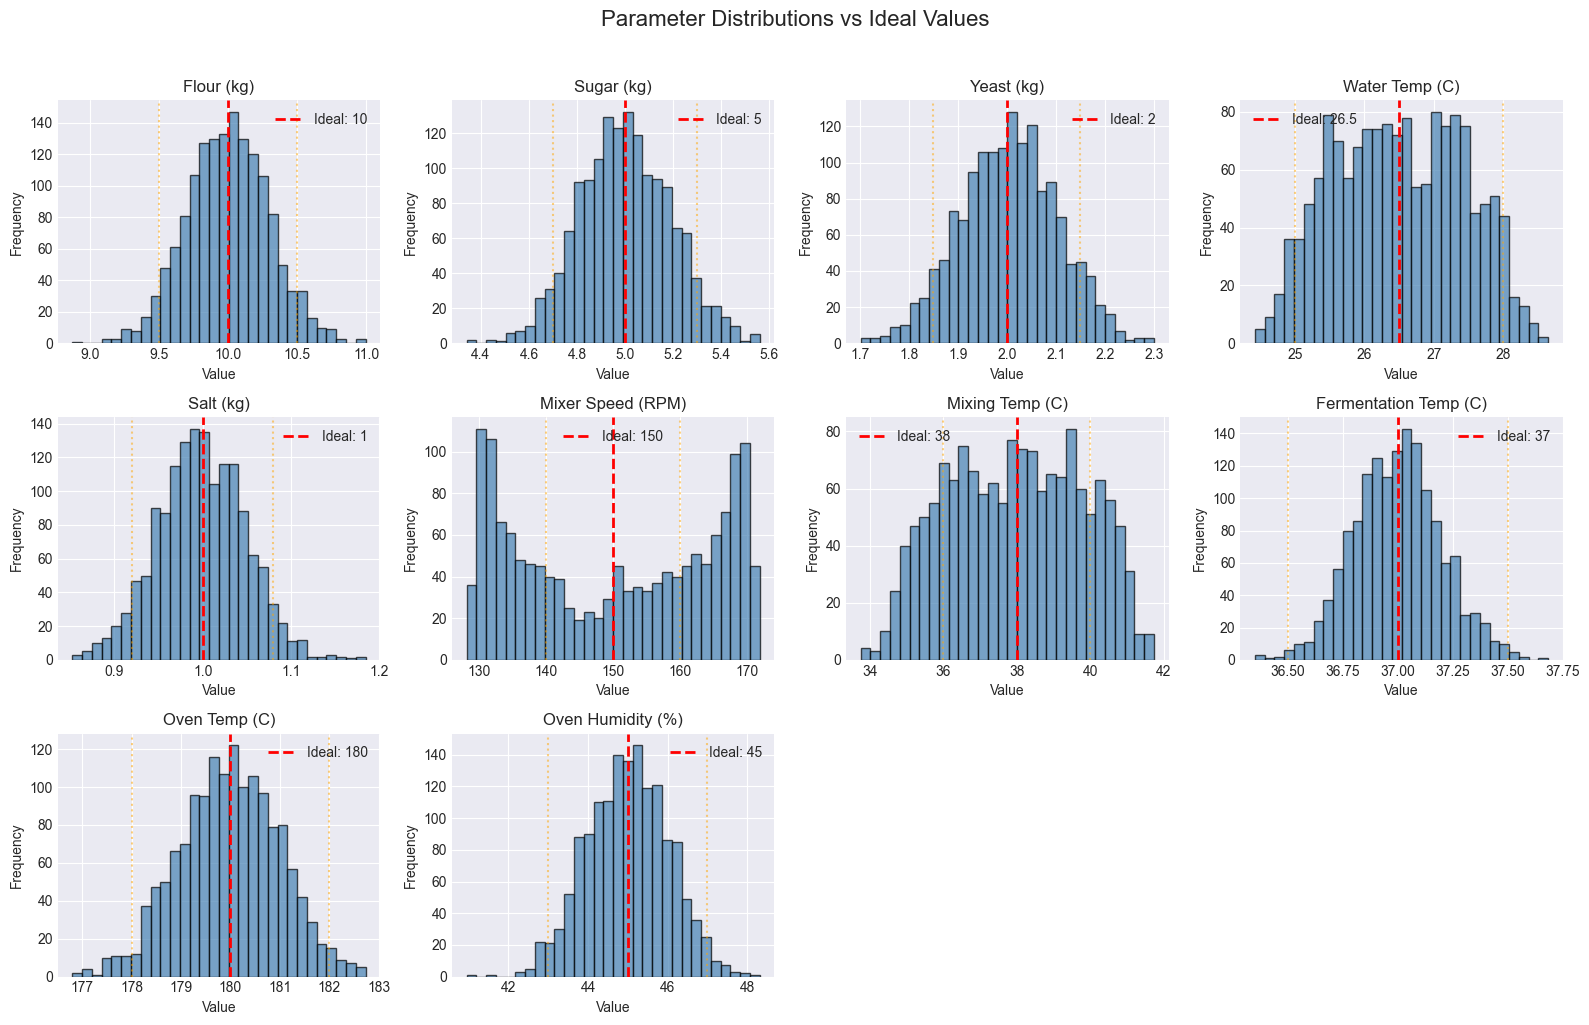

In [34]:
# Create distribution plots for all parameters
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, param in enumerate(process_params):
    ax = axes[idx]
    
    # Plot distribution
    ax.hist(clean_data[param], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Add ideal value line
    ideal = PROCESS_PARAMS[param]['ideal']
    ax.axvline(ideal, color='red', linestyle='--', linewidth=2, label=f'Ideal: {ideal}')
    
    # Add tolerance bands
    tolerance = PROCESS_PARAMS[param]['tolerance']
    ax.axvline(ideal - tolerance, color='orange', linestyle=':', alpha=0.5)
    ax.axvline(ideal + tolerance, color='orange', linestyle=':', alpha=0.5)
    
    ax.set_title(param)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

# Hide extra subplots
for idx in range(len(process_params), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Parameter Distributions vs Ideal Values', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 5. Outlier Detection

In [1]:
#Detect outliers using IQR method
outlier_flags = processor.detect_outliers(clean_data, method='iqr')

# Count outliers per parameter
outlier_summary = pd.DataFrame({
    'Parameter': [col.replace('_outlier', '') for col in outlier_flags.columns],
    'Outlier Count': outlier_flags.sum().values,
    'Outlier %': (outlier_flags.sum() / len(clean_data) * 100).values
})

outlier_summary = outlier_summary.sort_values('Outlier %', ascending=False)
print("Outlier Summary:")
print(outlier_summary)

# Visualize outliers with boxplots
fig = make_subplots(
    rows=2, cols=5,
    subplot_titles=process_params,
    vertical_spacing=0.15
)

for idx, param in enumerate(process_params):
    row = idx // 5 + 1
    col = idx % 5 + 1
    
    fig.add_trace(
        go.Box(
            y=clean_data[param],
            name=param,
            boxmean='sd',
            marker_color='lightblue'
        ),
        row=row, col=col
    )

fig.update_layout(
    title='Outlier Detection - Box Plots',
    showlegend=False,
    height=600
)

# fig.show()

NameError: name 'processor' is not defined

# 6. Time Series Analysis

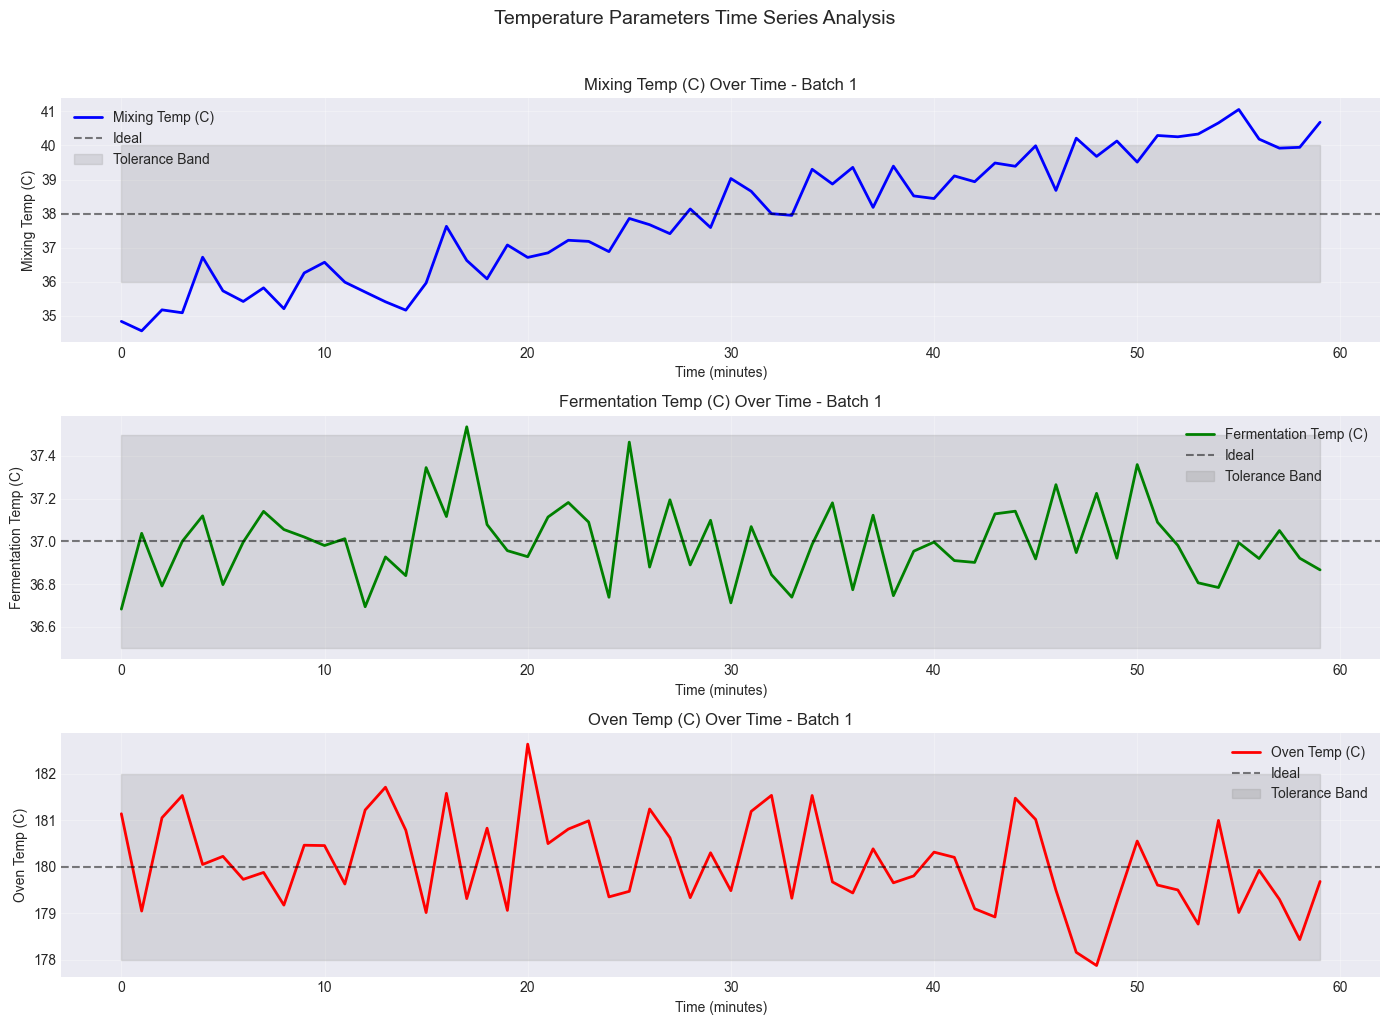

In [ ]:
# Analyze time series for a sample batch
sample_batch = clean_data[clean_data['Batch_ID'] == 1]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Temperature parameters
temp_params = ['Mixing Temp (C)', 'Fermentation Temp (C)', 'Oven Temp (C)']
colors = ['blue', 'green', 'red']

for idx, (param, color) in enumerate(zip(temp_params, colors)):
    ax = axes[idx]
    
    # Plot time series
    ax.plot(sample_batch['Time'], sample_batch[param], 
            color=color, linewidth=2, label=param)
    
    # Add ideal value and tolerance bands
    ideal = PROCESS_PARAMS[param]['ideal']
    tolerance = PROCESS_PARAMS[param]['tolerance']
    
    ax.axhline(ideal, color='black', linestyle='--', alpha=0.5, label='Ideal')
    ax.fill_between(sample_batch['Time'], 
                    ideal - tolerance, ideal + tolerance,
                    alpha=0.2, color='gray', label='Tolerance Band')
    
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel(f'{param}')
    ax.set_title(f'{param} Over Time - Batch 1')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Temperature Parameters Time Series Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 7. Correlation Analysis

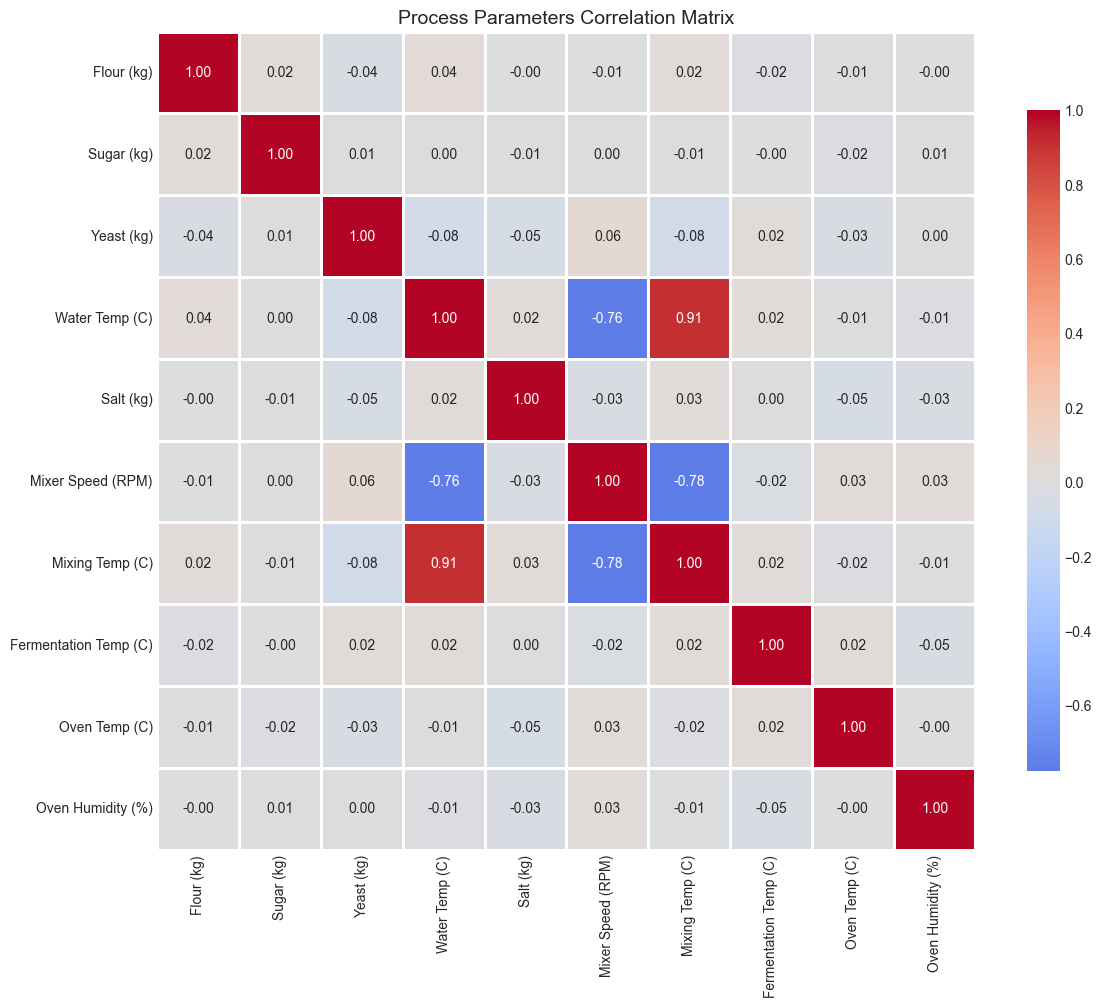


Strong Correlations (|r| > 0.5):
         Parameter 1        Parameter 2  Correlation
1     Water Temp (C)    Mixing Temp (C)     0.905314
2  Mixer Speed (RPM)    Mixing Temp (C)    -0.777703
0     Water Temp (C)  Mixer Speed (RPM)    -0.764395


In [ ]:
# Calculate correlation matrix
correlation_matrix = clean_data[process_params].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Process Parameters Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Find strong correlations
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            strong_correlations.append({
                'Parameter 1': correlation_matrix.columns[i],
                'Parameter 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if strong_correlations:
    print("\nStrong Correlations (|r| > 0.5):")
    print(pd.DataFrame(strong_correlations).sort_values('Correlation', 
                                                       key=abs, 
                                                       ascending=False))



# 8. Batch-wise Analysis

In [ ]:
# Analyze batch-wise statistics
batch_stats = clean_data.groupby('Batch_ID')[process_params].agg(['mean', 'std'])

# Calculate quality metrics for each batch (using simulated data)
batch_quality = pd.DataFrame(quality_data).T
batch_quality.index.name = 'Batch_ID'

print("Batch-wise Statistics (First 5 batches):")
print(batch_stats.head())

# Identify best and worst performing batches
if 'Quality Score' in batch_quality.columns:
    best_batches = batch_quality.nlargest(5, 'Quality Score')
    worst_batches = batch_quality.nsmallest(5, 'Quality Score')
    
    print("Top 5 Best Quality Batches:")
    print(best_batches)
    print("\nBottom 5 Worst Quality Batches:")
    print(worst_batches)







Batch-wise Statistics (First 5 batches):
         Flour (kg)           Sugar (kg)           Yeast (kg)            \
               mean       std       mean       std       mean       std   
Batch_ID                                                                  
1          9.970360  0.258529   4.971863  0.189242   2.011490  0.092035   
2         10.033188  0.267176   4.961258  0.182626   1.987529  0.084448   
3          9.930110  0.332547   4.976926  0.214315   1.998987  0.109859   
4          9.981613  0.315475   5.029651  0.195760   1.982227  0.104986   
5          9.984823  0.255384   5.037456  0.195456   2.001497  0.103189   

         Water Temp (C)           Salt (kg)           Mixer Speed (RPM)  \
                   mean       std      mean       std              mean   
Batch_ID                                                                  
1             26.470261  0.921196  1.019163  0.048211        150.430115   
2             26.508925  0.887126  0.987527  0.054065     

# 9. Deviation Analysis

In [ ]:
# !pip install nbformat

You should consider upgrading via the 'D:\NoSQL\Honeywell\gcvenv\Scripts\python.exe -m pip install --upgrade pip' command.


# 10. Key Findings and Insights

In [ ]:
# Generate comprehensive data quality report
quality_report = processor.generate_data_quality_report(clean_data)

print("="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)

print(f"\n1. Dataset Overview:")
print(f"   - Total records: {quality_report['total_rows']:,}")
print(f"   - Total features: {quality_report['total_columns']}")
print(f"   - Number of batches: {clean_data['Batch_ID'].nunique()}")
print(f"   - Time points per batch: {clean_data.groupby('Batch_ID').size().mean():.0f}")

print(f"\n2. Data Quality:")
print(f"   - Missing values: {len(quality_report['missing_values'])} columns")
print(f"   - Outliers detected: {len(quality_report['outliers'])} parameters")

print(f"\n3. Key Observations:")
print(f"   - Most variable parameter: {cv_analysis.iloc[0]['Parameter']} (CV: {cv_analysis.iloc[0]['CV (%)']:.1f}%)")
print(f"   - Most stable parameter: {cv_analysis.iloc[-1]['Parameter']} (CV: {cv_analysis.iloc[-1]['CV (%)']:.1f}%)")
print(f"   - Parameters with high outliers: {outlier_summary[outlier_summary['Outlier %'] > 5]['Parameter'].tolist()}")

print(f"\n4. Process Insights:")
for param, config in PROCESS_PARAMS.items():
    if param in clean_data.columns:
        mean_val = clean_data[param].mean()
        ideal_val = config['ideal']
        deviation = ((mean_val - ideal_val) / ideal_val) * 100
        if abs(deviation) > 5:
            print(f"   - {param}: Average {deviation:+.1f}% from ideal")

print(f"\n5. Recommendations for Model Training:")
print(f"   - Focus on high-variance parameters for anomaly detection")
print(f"   - Consider time-series features for temperature parameters")
print(f"   - Include interaction features between correlated parameters")
print(f"   - Apply outlier treatment for robust model training")

print("="*60)

2025-08-23 19:26:42.710 | INFO     | src.data_processor:generate_data_quality_report:324 - Generating data quality report
2025-08-23 19:26:42.714 | INFO     | src.data_processor:detect_outliers:138 - Detecting outliers using iqr method
2025-08-23 19:26:42.738 | INFO     | src.data_processor:detect_outliers:161 - Total outliers detected: 66
2025-08-23 19:26:42.769 | INFO     | src.data_processor:generate_data_quality_report:367 - Data quality report generated


DATA EXPLORATION SUMMARY

1. Dataset Overview:
   - Total records: 1,500
   - Total features: 12
   - Number of batches: 25
   - Time points per batch: 60

2. Data Quality:
   - Missing values: 0 columns
   - Outliers detected: 7 parameters

3. Key Observations:
   - Most variable parameter: Mixer Speed (RPM) (CV: 9.7%)
   - Most stable parameter: Fermentation Temp (C) (CV: 0.5%)
   - Parameters with high outliers: []

4. Process Insights:

5. Recommendations for Model Training:
   - Focus on high-variance parameters for anomaly detection
   - Consider time-series features for temperature parameters
   - Include interaction features between correlated parameters
   - Apply outlier treatment for robust model training
